In [8]:
import urllib3

def get_request(uri):
    ua = "Mozilla/5.0 (Linux; U; Android 2.2; en-us; Nexus One Build/FRF91) AppleWebKit/533.1 (KHTML, like Gecko) Version/4.0 Mobile Safari/533.1"  
    h = {"User-Agent": ua}
    httpPool = urllib3.PoolManager()
    return httpPool.request('GET',uri,fields=None,headers=h)

In [9]:
import json

from bs4 import BeautifulSoup


with open('URL.json',"r") as f:
    urls = json.load(f)

DATA = list(map(lambda x: [x['name'],x['URL'],x['HTML'],x['class']],urls['periodicos']))

textos=[]
for dato in DATA:
    soup = BeautifulSoup(get_request(dato[1]).data,'html.parser')
    textos.append(list(map(lambda x:x.text,soup.find_all(dato[2],{"class":dato[3]}))))

In [10]:
textoLimpio = []
caracterBasura="\n"
textosSinCaracterBasura=[]
for value in textos:
    textosSinCaracterBasura.append([x.replace(caracterBasura,'') for x in value])

for index,value in enumerate(textos):
    textoLimpio.append(list(map(lambda x:" ".join(list(filter(lambda y:len(str(y))>3,(x.split(" "))))),textosSinCaracterBasura[index])))

In [11]:
textoUnido = [y for x in textoLimpio for y in x]

In [12]:
# Menos óptimo

# PALABRA CON VALOR
palabraValor={}

# FRASES CON MÁS PUNTUACIÓN
frasesTotalValor=[]

for frase in textoUnido:
    fraseValores=[]
    for palabra in frase.split(" "):
        valor=0
        for frase in textoUnido:
            valor+=frase.count(palabra)
        palabraValor[palabra.lower()] = valor
        fraseValores.append(valor)
    frasesTotalValor.append(sum(fraseValores)/len(fraseValores))

In [13]:
frasesTotalValor = list(map(lambda x:x/max(frasesTotalValor),frasesTotalValor))
frasesTotalValor

[0.10714285714285715,
 0.1466346153846154,
 0.3490384615384616,
 0.3490384615384616,
 0.04487179487179488,
 0.05244755244755245,
 0.35192307692307695,
 0.1418269230769231,
 0.10336538461538462,
 0.09440559440559441,
 0.29108391608391615,
 0.0625,
 0.09065934065934067,
 0.054086538461538464,
 0.20192307692307693,
 0.057692307692307696,
 0.14423076923076925,
 0.03605769230769231,
 0.08653846153846155,
 0.15705128205128208,
 0.14743589743589744,
 0.04945054945054945,
 0.08314479638009051,
 0.061813186813186816,
 0.0625,
 0.14685314685314685,
 0.03605769230769231,
 0.04945054945054945,
 0.07932692307692309,
 0.4532967032967033,
 0.043269230769230775,
 0.038461538461538464,
 0.028846153846153848,
 0.08241758241758243,
 0.028846153846153848,
 0.4759615384615385,
 0.06593406593406594,
 0.3251748251748252,
 0.057692307692307696,
 0.11538461538461539,
 0.07005494505494506,
 0.04945054945054945,
 0.13141025641025642,
 0.06923076923076923,
 0.125,
 0.29955621301775154,
 0.10714285714285715,
 0.08

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'para'),
  Text(1, 0, 'acción'),
  Text(2, 0, 'madrid'),
  Text(3, 0, 'come'),
  Text(4, 0, 'ante'),
  Text(5, 0, 'comentarios'),
  Text(6, 0, 'esta'),
  Text(7, 0, 'años'),
  Text(8, 0, 'barça'),
  Text(9, 0, 'contra')])

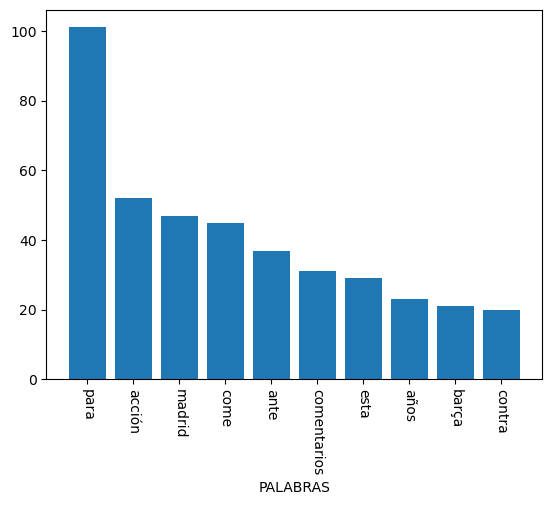

In [14]:
import matplotlib.pyplot as plt
from pandas import DataFrame

diccionario_ordenado = sorted(palabraValor.items(), key=lambda x: x[1], reverse=True)
diez_mas_grandes = dict(diccionario_ordenado[:10])

plt.bar(diez_mas_grandes.keys(),diez_mas_grandes.values())
plt.xlabel("PALABRAS")
plt.xticks(rotation=-90)